In [1]:
# Checking the calibration data at a further distance
# dist = 12cm vs previous 3.4 cm

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import spinmob as s

In [230]:
'''
giving a fitter, returns an array of the fitted lorentzian1 parameters and errors in 2D array
arg: my_fitter = fit, x = integer value offset

'''
def getFits_lor(my_fitter, x):
    
    di = my_fitter.get_fit_results()
    results = [di[key] for key in di.keys()]
    
#     E0 = [results[0+6*x], results[1+6*x]]
    center = [results[0+8*x], results[1+8*x]]
    dist = [results[2+8*x], results[3+8*x]]
    gamma = [results[4+8*x], results[5+8*x]]
    A = [results[6+8*x], results[7+8*x]]

    return [center, dist, gamma, A]

"""
Takes array of channels, and m, b of linear function
Returns array of velocities [mmsec]
"""
def chan_to_velo(channels, m, b):
    v = [m[0]*c + b[0] for c in channels]
#     vE = 
    
    return v

"""
"""
def average(a, b, offset):
    
    center = (a[0] - b[0]) / 2.0 + offset[0]
    err = np.sqrt((np.sqrt((a[1])**2 + (b[1])**2)*0.5)**2+(offset[1])**2)
    
    return [center, err]
    

#one lorentzians with offset
def lorentzian(E, E0, gamma, A, b):
    denom = (E-E0)**2 + (gamma/2)**2
    return A*gamma**2/denom + b

#2 lorentzians added together with one offset
def lorentzian2(E, E0, gamma, A, E0_2, gamma_2, A_2, b):
    denom = (E-E0)**2 + (gamma/2)**2
    denom_2 = (E-E0_2)**2 + (gamma_2/2)**2

    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + b

#6 lorentzians added together with one offset
def lorentzian6(E, E0, gamma, A, E0_2, gamma_2, A_2, E0_3, gamma_3, A_3, E0_4, gamma_4, A_4, E0_5, gamma_5, A_5, E0_6, gamma_6, A_6, b):
    denom = (E-E0)**2 + (gamma/2)**2
    denom_2 = (E-E0_2)**2 + (gamma_2/2)**2
    denom_3 = (E-E0_3)**2 + (gamma_3/2)**2
    denom_4 = (E-E0_4)**2 + (gamma_4/2)**2
    denom_5 = (E-E0_5)**2 + (gamma_5/2)**2
    denom_6 = (E-E0_6)**2 + (gamma_6/2)**2

    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_4*gamma_4**2/denom_4 + A_5*gamma_5**2/denom_5 + A_6*gamma_6**2/denom_6 + b

#2 lorentzians added together with one offset
def lorentzian2Const(E, center, dist, gamma, A, b):
    denom = (E- (center - dist) )**2 + (gamma/2)**2
    denom_2 = (E- (center + dist) )**2 + (gamma/2)**2

    return A*gamma**2/denom + A*gamma**2/denom_2 + b


def lorentzian6const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, center_3, dist_3, gamma_3, A_3, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_3 = (E-(center_3 - dist_3))**2 + (gamma_3/2)**2
    denom_4 = (E-(center_3 + dist_3))**2 + (gamma_3/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_3*gamma_3**2/denom_4 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b

def lorentzian4const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b
    
    

In [240]:

# channel to velocity relation from calibration data
b = [11.000776381475806, 0.0011164921537570854] 
m = [-0.08527733629051013, 8.194955387410484e-06]

## Temperture scaling
Yttrium orthoferrite  
Looking for Neel temperature

In [241]:
'''
data - data loaded from np.loadtxt
guess - string of guesses of parameters for lor fit
peak - number of peaks to fit (currently either 2 or 6)
'''
def fitYtt(data, guess, peaks):
    data = np.transpose(data)
    data[1][511] = (data[1][510] + data[1][0])/2
    ydataerr = np.sqrt(data[1])

    dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
    
    velocities = chan_to_velo(dataL[0], m, b)

    my_fitter = s.data.fitter()
    my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
                  , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

    if peaks == 6: 
    #6 fit
        my_fitter.set_functions(f=lorentzian6const, p=guess)

        my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
        my_fitter.fit()
        # print(my_fitter.get_fit_results())

        results = [getFits_lor(my_fitter, 0), getFits_lor(my_fitter, 1), getFits_lor(my_fitter, 2)]
    if peaks == 2: 
    #4 fit
        my_fitter.set_functions(f=lorentzian2Const, p=guess)

        my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
        my_fitter.fit()
        # print(my_fitter.get_fit_results())

        results = [getFits_lor(my_fitter, 0)]
    
    return results

In [244]:
#Yttrium orthoferrite
data = np.loadtxt(".//data//Y_ortho_T256_Jan20_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

tempPoints = [[],[], []]

### Fitting Data from malfunctioning oven

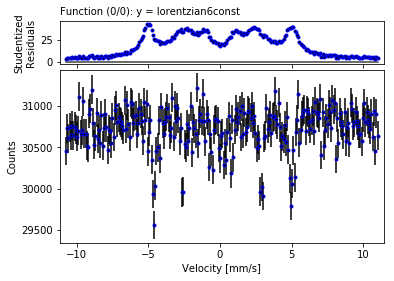

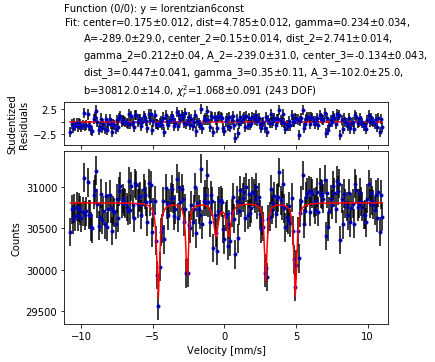

In [245]:
data_T256 = np.loadtxt(".//data//Y_ortho_T256_Jan20_full.Asc", skiprows=0)
guess_T256 = 'center=0, dist=5, gamma=1, A=-1500, center_2=0, dist_2=2.5, gamma_2=2, A_2=-1300, center_3=0, dist_3=1.0, gamma_3=1, A_3=-800, b=3e4'

fit_T256 = fitYtt(data_T256, guess_T256, 6)
# print(fit_T256[2])

tempPoints[0].append(256)
tempPoints[1].append(fit_T256[2][1][0])
# tempPoints[2].append(fit_T367[2][1][1])

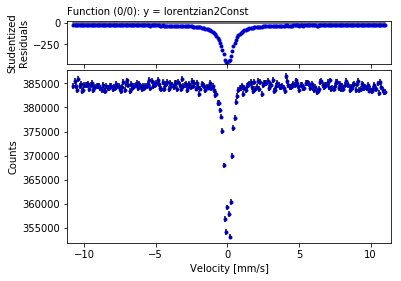

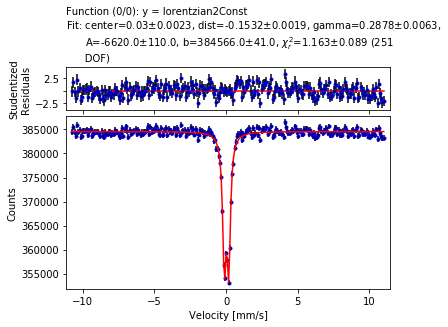

In [246]:
data_T358 = np.loadtxt(".//data//Y_ortho_T358_Jan21_full.Asc", skiprows=0)
# guess_T358 = 'center=0, dist=0.5, gamma=1, A=-1e3, center_2=0, dist_2=2.4, gamma_2=2, A_2=1e3, center_3=0, dist_3=5, gamma_3=2, A_3=1e3, b=3e4'

# fit_T358 = fitYtt(data_T358, guess_T358, 6)

guess_T358 = 'center=0, dist=0.1, gamma=1, A=3e4, b=4e5'
fit_T358 = fitYtt(data_T358, guess_T358, 2)

tempPoints[0].append(358)
tempPoints[1].append(fit_T358[0][1][0])
tempPoints[2].append(fit_T367[0][1][1])

# center, dist, gamma, A, b

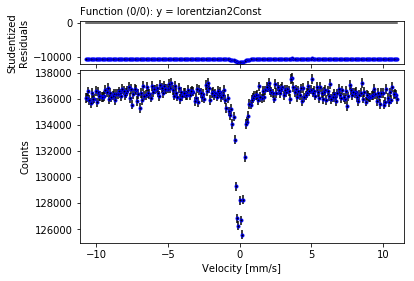

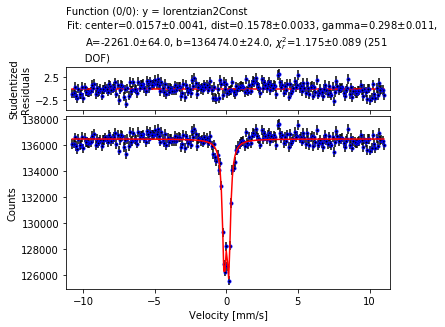

In [247]:
data_T365 = np.loadtxt(".//data//Y_ortho_T365_Jan21_full.Asc", skiprows=0)
guess_T365 = 'center=0, dist=0.1, gamma=1, A=3e4, b=4e6'

fit_T365 = fitYtt(data_T365, guess_T365, 2)
tempPoints[0].append(365)
tempPoints[1].append(fit_T365[0][1][0])
tempPoints[2].append(fit_T367[0][1][1])

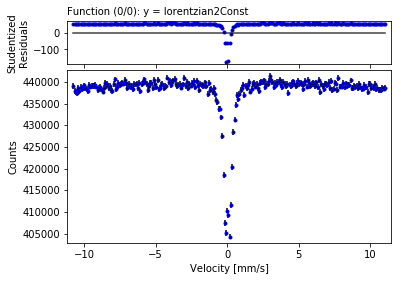

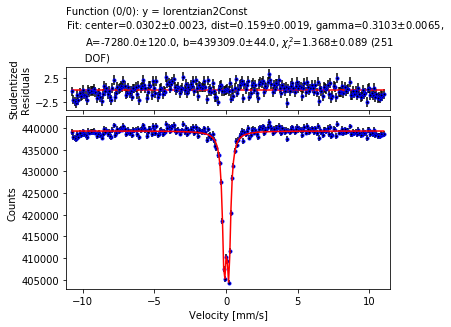

In [248]:
data_T367 = np.loadtxt(".//data//Y_ortho_T367_Jan22_full.Asc", skiprows=0)
guess_T367 = 'center=0, dist=0.1, gamma=0.1, A=3e4, b=4e5'

fit_T367 = fitYtt(data_T367, guess_T367, 2)
tempPoints[0].append(367)
tempPoints[1].append(fit_T367[0][1][0])
tempPoints[2].append(fit_T367[0][1][1])

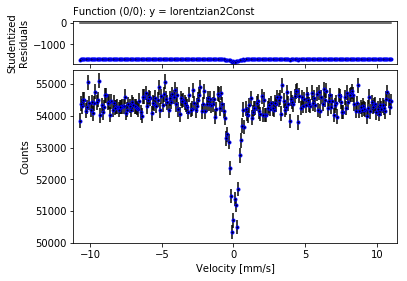

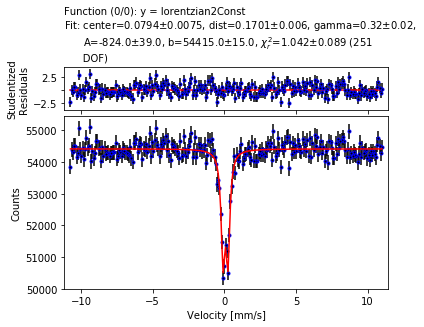

In [249]:
data_T309 = np.loadtxt(".//data//Y_ortho_T309_Jan22_full.Asc", skiprows=0)
guess_T309 = 'center=0, dist=0.1, gamma=0.1, A=3e3, b=45e4'

fit_T309 = fitYtt(data_T309, guess_T309, 2)
tempPoints[0].append(309)
tempPoints[1].append(fit_T309[0][1][0])
tempPoints[2].append(fit_T309[0][1][1])

<function matplotlib.pyplot.show(*args, **kw)>

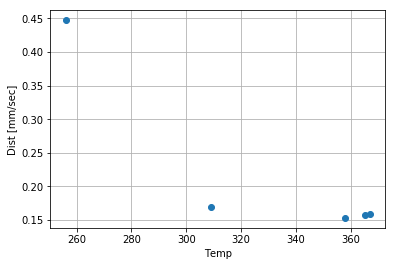

In [265]:
#distance of calibration outside peaks
cal = [5.31149, 0.00055]

err = [np.abs(i) for i in tempPoints[2]]

plt.errorbar(tempPoints[0], np.abs(tempPoints[1]), yerr=0, linestyle=" ", marker="o")
# plt.axhline(cal[0], color='g')

# tempPoints[2]

plt.grid()
plt.ylabel('Dist [mm/sec]')
plt.xlabel('Temp')

plt.show